In [1]:
import pandas as pd
import backtrader as bt
import datetime
# Load your data
df = pd.read_csv('ohlc_data/0_61938.csv')

# # Ensure required columns exist
# df = df[['open', 'high', 'low', 'close', 'volume', 'signal']]

In [12]:
df = df.iloc[0:5000]

In [13]:
df.Signal.value_counts()

Signal
0    4804
1     102
2      94
Name: count, dtype: int64

In [4]:
# Create datetime index: each row is 1 hours apart from the previous one
start_date = datetime.datetime(2020, 1, 1)  # or choose your own
df['datetime'] = [start_date + datetime.timedelta(hours=1 * i) for i in range(len(df))]

# Set datetime as index
df.set_index('datetime', inplace=True)

In [5]:
df['signal'] = df['Signal']

In [14]:
class PandasSignalData(bt.feeds.PandasData):
    lines = ('signal',)
    params = (('signal', -1),)  # -1 means auto-map 'signal' column

In [15]:
class SignalStrategy(bt.Strategy):
    def next(self):
        signal = self.datas[0].signal[0]  # current signal

        if signal == 2:  # Buy
            if not self.position:
                self.buy()

        elif signal == 1:  # Sell
            if self.position:
                self.sell()

        # Hold (0): do nothing


<IPython.core.display.Javascript object>


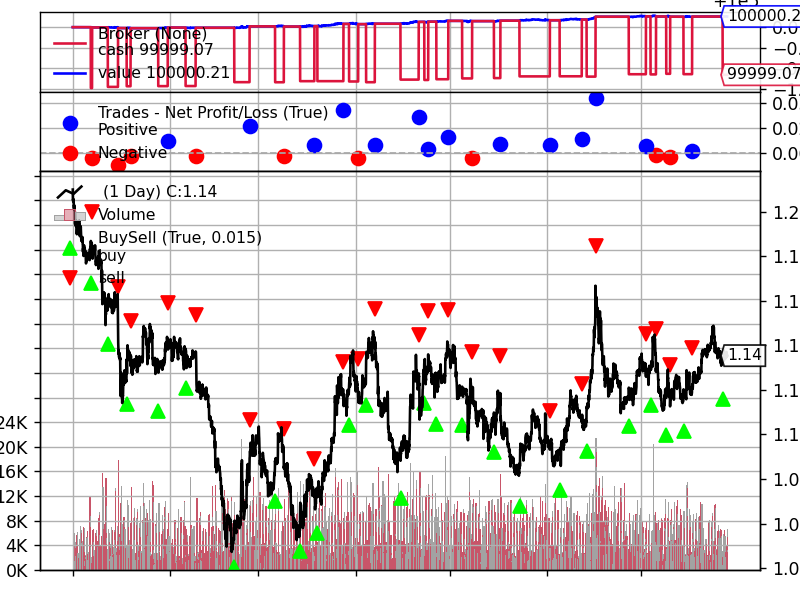

[[<Figure size 640x480 with 4 Axes>]]

In [16]:
# Initialize the engine
cerebro = bt.Cerebro()
cerebro.addstrategy(SignalStrategy)

# Feed your data
data_feed = PandasSignalData(dataname=df)
cerebro.adddata(data_feed)

# Set initial capital
cerebro.broker.setcash(100000)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

# Run the backtest
results = cerebro.run()
strategy = results[0]

# Plot the result
cerebro.plot()


In [17]:
# Sharpe Ratio
sharpe = strategy.analyzers.sharpe.get_analysis()
print("Sharpe Ratio:", sharpe.get('sharperatio', 'N/A'))

# Drawdown
dd = strategy.analyzers.drawdown.get_analysis()
print(f"Max Drawdown: {dd['max']['drawdown']}%")
print(f"Drawdown Duration: {dd['max']['len']} bars")

# Returns
returns = strategy.analyzers.returns.get_analysis()
print("Total Return: {:.2f}%".format(returns['rtot'] * 100))
print("Annual Return: {:.2f}%".format(returns['rannual'] * 100))

# Trades
trades = strategy.analyzers.trades.get_analysis()
print("Total Trades:", trades.total.closed)
print("Win Rate [%]:", 100 * trades.won.total / trades.total.closed if trades.total.closed else 0)
print("Avg. Profit [%]:", trades.pnl.net.average if trades.pnl.net.average else 0)


Sharpe Ratio: None
Max Drawdown: 2.8599963494385595e-05%
Drawdown Duration: 964 bars
Total Return: 0.00%


KeyError: 'rannual'

In [22]:
class SignalStrategy(Strategy):
    def init(self):
        self.signal = self.data.signal  # Predefined signal column

    def next(self):
        if self.signal[-1] == 'buy' or self.signal[-1] == 2:
            self.buy()
        elif self.signal[-1] == 'sell' or self.signal[-1] == 1:
            self.sell()
        # 'hold' or 0: do nothing


In [23]:
bt = Backtest(df, SignalStrategy,
              cash=10000, commission=.002,
              exclusive_orders=True)

stats = bt.run()

In [24]:
bt.plot()

C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1509', ...)

In [26]:
stats

Start                     2020-01-01 00:00:00
End                       2020-07-27 07:00:00
Duration                    208 days 07:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                -6.16534
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [18]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

class SmaCross(Strategy):
    n1 = 10
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


bt = Backtest(GOOG, SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot()

C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [25]:
output

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                   97.067039
Equity Final [$]                  68221.96986
Equity Peak [$]                   68991.21986
Return [%]                         582.219699
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                   25.266427
Volatility (Ann.) [%]               38.383008
Sharpe Ratio                         0.658271
Sortino Ratio                        1.288779
Calmar Ratio                         0.763748
Max. Drawdown [%]                  -33.082172
Avg. Drawdown [%]                   -5.581506
Max. Drawdown Duration      688 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                   94
Win Rate [%]                        54.255319
Best Trade [%]                       57.11931
Worst Trade [%]                    -16.629898
Avg. Trade [%]                    